_The main focus of this assignment is Building Recommendation Systems from theoretical as well as practical perspective_

## Problem 1: Implementing Recommendation Systems

We will be using the MovieLens data set from the GroupLens Research Project at the University of Minnesota for this question.The data set consists of 100,000 ratings, on a scale of 1 to 5 from 943 users on 1682 movies. Each user has rated at least 20 movies. The format of the input files is as follows:

Users and items are numbered consecutively from 1.  The data is randomly ordered. The dataset has the following schema:

	         user id | item id | rating | timestamp  

The goal of this exercise is to create implement collaborative filtering systems and evaluate their performance. Suggestions on which functions to use to make the develeopment faster are in the skeleton code below.

In [1]:
import numpy as np
import pandas as pd
# library to split your data into test and train
from sklearn import cross_validation as cv
# library to compute the distance metrics
from sklearn.metrics.pairwise import pairwise_distances
# library to compute the error
from sklearn.metrics import mean_squared_error
from math import sqrt

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# read in the data
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=header)

Before creating the recommender system, let's look at the data. Specifically, we'll take a look at the format, create a histogram of the ratings, and get a count for each rating.

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


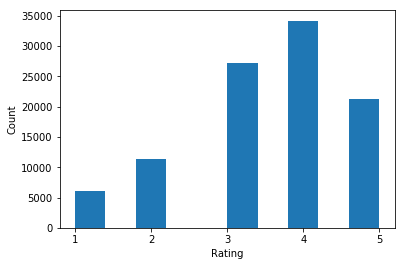

4    34174
3    27145
5    21201
2    11370
1     6110
Name: rating, dtype: int64

In [3]:
import matplotlib.pyplot as plt
print(df.head())
plt.hist(df['rating'])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1,6))
plt.show()
df['rating'].value_counts()

The distribution of ratings has a negative skew, as over 80% of movies have a favorable rating (3 stars or greater).

In [4]:
percentOver3Stars = df[df['rating'] >= 3].size/float(df.size)
print('%4.2f%% of movies have a 3 star or higher rating' % (percentOver3Stars*100))

82.52% of movies have a 3 star or higher rating


In [5]:
# function to compute the RMSE
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [6]:
# An example of how you can use the pairwise distance function to compute user similarity from sklearn. 
# Here we are using the cosine similairty metric to compute distances
# user_similarity = pairwise_distances(data_matrix, metric='cosine')

In [7]:
# An example on dividing youe data into train and test
#train_data, test_data = cv.train_test_split(df, test_size= 0.3)

We need to create matrix representations of our data set, with a user for each row, and items forming the columns. Before we do this, we shoud split the data into training and testing sets, using the cv module as shown above.

In [8]:
train_data, test_data = cv.train_test_split(df, test_size= 0.3, random_state = 327)

In [9]:
print(train_data.shape)
print(test_data.shape)

(70000, 4)
(30000, 4)


Now that we have our data split, we can create matrices for our training and testing data.

In [10]:
n_users = df['user_id'].unique().shape[0]
n_items = df['item_id'].unique().shape[0]
print('Total number of users: %i' % n_users)
print('Total number of items: %i' % n_items)

# Create train matrix
train_matrix = np.zeros((n_users, n_items))
for row in train_data.itertuples():
    train_matrix[row[1]-1,row[2]-1] = row[3]

# Create test matrix
test_matrix = np.zeros((n_users, n_items))
for row in test_data.itertuples():
    test_matrix[row[1]-1,row[2]-1] = row[3]

Total number of users: 943
Total number of items: 1682


Before we proceed, let's look at the sparsity of our data matrices.

In [11]:
def computeSparsity(matrix):
    sparsity = float(len(matrix.nonzero()[0]))
    sparsity /= matrix.shape[0] * matrix.shape[1]
    sparsity *= 100
    return sparsity

print('Training data matrix sparsity: %4.2f%%' % computeSparsity(train_matrix))
print('Test data matrix sparsity: %4.2f%%' % computeSparsity(test_matrix))

Training data matrix sparsity: 4.41%
Test data matrix sparsity: 1.89%


Both matrices are quite sparse, which is expected. The sparsity refers to the percent of the matrix which is non-zero (for example, 4.41% of the training data matrix entries are non-zero).

### Memory-Based

We can use the parwise_distances function to help compute both user and item similarity. User similarity computes the cosine similarity between rows (users), comparing only movies that both users have rated. Item similarity computes the cosine similarity between columns (items), comparing two movies only if a given user has rated both of them. The cosine similarity function actually takes care of this automatically, when a dot product is taken, if one or both items is zero that particular term will give zero contribution to the sum.

In [12]:
user_similarity = pairwise_distances(train_matrix, metric='cosine')
item_similarity = pairwise_distances(train_matrix.T, metric='cosine')
print(user_similarity.shape)
print(item_similarity.shape)

(943, 943)
(1682, 1682)


Let's take a look at the user similarity matrices:

In [13]:
print('User similarity:')
print(user_similarity)
print('Item similarity:')
print(item_similarity)

User similarity:
[[0.         0.8793868  0.94804391 ... 0.89961663 0.87662809 0.70410071]
 [0.8793868  0.         0.91856354 ... 0.84858515 0.84420374 0.90357713]
 [0.94804391 0.91856354 0.         ... 1.         0.85037346 0.96219653]
 ...
 [0.89961663 0.84858515 1.         ... 0.         0.88775238 0.92780116]
 [0.87662809 0.84420374 0.85037346 ... 0.88775238 0.         0.84194039]
 [0.70410071 0.90357713 0.96219653 ... 0.92780116 0.84194039 0.        ]]
Item similarity:
[[0.         0.69607843 0.74117154 ... 1.         0.94520548 1.        ]
 [0.69607843 0.         0.7791842  ... 1.         0.90638703 1.        ]
 [0.74117154 0.7791842  0.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 0.         1.         1.        ]
 [0.94520548 0.90638703 1.         ... 1.         0.         1.        ]
 [1.         1.         1.         ... 1.         1.         0.        ]]


Note that cosine distance is defined as one minus cosine similarity, and what we actually have above is the cosine distance. An example is shown below for the first two users, where the value from the user_similarity matrix is 0.8793868.

In [14]:
dp = np.dot(train_matrix[0,:],train_matrix[1,:])
factor = np.linalg.norm(train_matrix[0,:])*np.linalg.norm(train_matrix[1,:])
print('Cosine similarity between users 0 and 1 = %0.7f' % (dp/factor))
print('Cosine distance between users 0 and 1 = %0.7f' % (1-dp/factor))

Cosine similarity between users 0 and 1 = 0.1206132
Cosine distance between users 0 and 1 = 0.8793868


Note that because we need to use a similarity measure when making predictions, we should subtract the values we computed from the pairwise_distance function from one. This will convert the numbers from a distance measure to a similarity measure.

In [15]:
# Convert distance measure to similarity measure to use when making predictions
print('User similarity:')
print(1-user_similarity)
print('Item similarity:')
print(1-item_similarity)
user_similarity = 1 - user_similarity
item_similarity = 1 - item_similarity

User similarity:
[[1.         0.1206132  0.05195609 ... 0.10038337 0.12337191 0.29589929]
 [0.1206132  1.         0.08143646 ... 0.15141485 0.15579626 0.09642287]
 [0.05195609 0.08143646 1.         ... 0.         0.14962654 0.03780347]
 ...
 [0.10038337 0.15141485 0.         ... 1.         0.11224762 0.07219884]
 [0.12337191 0.15579626 0.14962654 ... 0.11224762 1.         0.15805961]
 [0.29589929 0.09642287 0.03780347 ... 0.07219884 0.15805961 1.        ]]
Item similarity:
[[1.         0.30392157 0.25882846 ... 0.         0.05479452 0.        ]
 [0.30392157 1.         0.2208158  ... 0.         0.09361297 0.        ]
 [0.25882846 0.2208158  1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.05479452 0.09361297 0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


Before we go on to making predictions, let's look at the distribution of our similarity matrices. It's worth observing how similar most users are to one another, as this will influence the quality of our predictions.

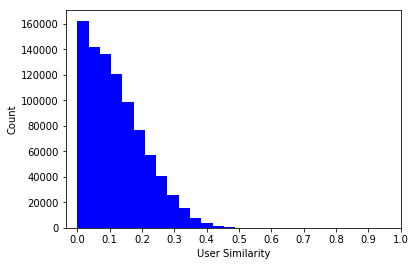

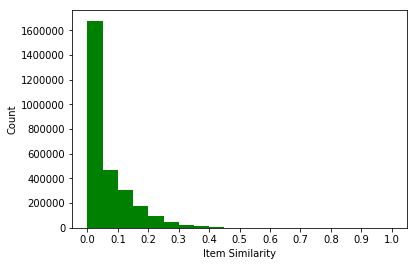

In [16]:
plt.hist(user_similarity[np.where(user_similarity < 1)].flatten(), bins=20, color='blue')
plt.xlabel('User Similarity')
plt.xticks(np.array(range(0,11))/float(10))
plt.ylabel('Count')
plt.show()
plt.hist(item_similarity[np.where(item_similarity < 1)].flatten(), bins=20, color='green')
plt.xlabel('Item Similarity')
plt.xticks(np.array(range(0,11))/float(10))
plt.ylabel('Count')
plt.show()

Note that there are no similarity values greater than 0.5. This means that most users are not that similar to one another, and relatively small weights will be applied to each review when predicting ratings.

Now that we have our training data and similarity matrices, we can predict user ratings for our test data. We'll try two different methods, one where we account for individual user bias and one where we don't.

### Standard Collaborative Filtering (no bias correction)

First, we'll compute similarity without accounting for individual user bias. To predict an average weighting, we simply multiply the similarity matrix by the user ratings matrix, and normalize the result. Essentially, we're creating a similarity weighted average, since for each user and movie, we sum the product of the ratings for the movie and the similarity of each user and divide out the sum of the similarity.

In [17]:
def predict_biased(ratings, similarity, type='user'):
    if type == 'user':
        predict = np.matmul(similarity, ratings)
        normalize = np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        predict = np.matmul(ratings, similarity)
        normalize = np.array([np.abs(similarity.sum(axis=1))])
    return predict/normalize

Now, we can create predictions using the training matrix and evaluate the quality on the test matrix using the RMSE function defined above.

In [18]:
predict_user = predict_biased(train_matrix, user_similarity, type='user')
predict_item = predict_biased(train_matrix, item_similarity, type='item')
print('User-based CF RMSE (biased): %4.2f' % rmse(predict_user,test_matrix))
print('Item-based CF RMSE (biased): %4.2f' % rmse(predict_item,test_matrix))

User-based CF RMSE (biased): 3.09
Item-based CF RMSE (biased): 3.21


User-based collaborative filtering produced a lower test RMSE compared to item-based. The RMSE represents the standard deviation of the residuals (predicted minus actual ratings), and a smaller number indicates a better fit. It can also be thought of as the average difference between predicted and actual ratings. In that sense, a value of ~3 is quite high, as the range of reviews is 1-5.

### Standard Collaborative Filtering (bias correction)

Now, we'll compute similarity while accounting for individual user bias. This is similar to the first method, except we'll subtract each users average rating for all movies before computing the sum of the similarity and ratings. Before returning the result, we add the average rating back in.

In [19]:
def predict_unbiased(ratings, similarity, type='user'):
    if type == 'user':
        avg_rating = np.mean(ratings, axis=1)
        ratings = (ratings - avg_rating[:, np.newaxis]).copy()
        predict = np.matmul(similarity, ratings)
        normalize = np.array([np.abs(similarity).sum(axis=1)]).T
        predict = predict/normalize + avg_rating[:, np.newaxis]
    elif type == 'item':
        avg_rating = np.mean(ratings, axis=0)
        ratings = (ratings - avg_rating[np.newaxis, :]).copy()
        predict = np.matmul(ratings, similarity)
        normalize = np.array([np.abs(similarity).sum(axis=1)])
        predict = predict/normalize + avg_rating[np.newaxis, :]
    return predict

In [20]:
predict_user = predict_unbiased(train_matrix, user_similarity, type='user')
predict_item = predict_unbiased(train_matrix, item_similarity, type='item')
print('User-based RMSE (unbiased): %4.2f' % rmse(predict_user,test_matrix))
print('Item-based RMSE (unbiased): %4.2f' % rmse(predict_item,test_matrix))

User-based RMSE (unbiased): 3.01
Item-based RMSE (unbiased): 3.03


Note that removing user bias before computing the predictions results in a slightly lower RMSE value. The values are still somewhat high, as noted above the range of the ratings is 1-5, and the average difference between the predicted and actual ratings is approximately 3.

### Model Based

We can also try a model based approach, to see if we can improve the quality of the recommendations. In particular, we'll use singular value decomposition (SVD) to create a low-rank approximation to the training data matrix, and use that to make predictions on the test data.

In [21]:
from numpy.linalg import svd

U,S,VT = svd(train_matrix)

Let's take a look at the singular values, to see if there are a few that explain a majority of the variance within the training data matrix.

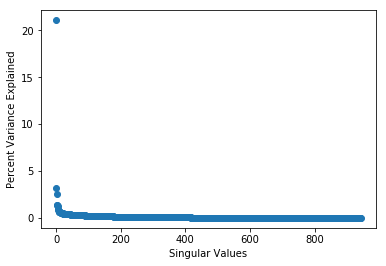

In [22]:
Spercent = S**2/np.sum(S**2)*100
plt.scatter(range(len(S)),Spercent)
plt.xlabel('Singular Values')
plt.ylabel('Percent Variance Explained')
plt.show()

We can also view this as an accumulation of the percent variance explained.

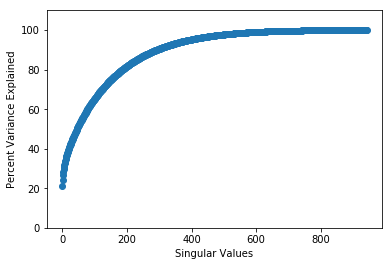

In [23]:
Scumpercent = np.cumsum(S**2)/np.sum(S**2)*100
plt.scatter(range(len(S)),Scumpercent)
plt.xlabel('Singular Values')
plt.ylabel('Percent Variance Explained')
plt.ylim([0,110])
plt.show()

As explained before, we can approximate the training matrix by creating low-rank approximations using a reduced set of the singular values. Since there isn't a definitive 'elbow' in the plot shown above, lets vary the number of singular values used and create a plot of the RMSE.

In [24]:
k_vec = []
rmse_vec = []
for k in range(1,101):
    train_matrix_approx = np.matmul(np.matmul(U[:,:k],np.diag(S[:k])),VT[:k,:])
    k_vec.append(k)
    rmse_vec.append(rmse(train_matrix_approx,test_matrix))

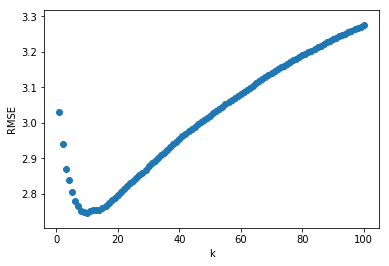

In [25]:
plt.scatter(k_vec,rmse_vec)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.show()

It looks like the minimum RMSE occurs somewhere around k=10. We can calculate the exact value:

In [26]:
print('Mininum RMSE: %6.4f' % np.amin(rmse_vec))
print('Corresponding value of k: %i' % k_vec[np.where(rmse_vec==np.amin(rmse_vec))[0][0]])

Mininum RMSE: 2.7454
Corresponding value of k: 10


The value of k that produces the minimum RMSE is indeed 10, and this RMSE is substantially lower than that of the memory-based CF approach. In addition, we did this using only 10 out of 943 singular values. This means we only need to store a fraction of the original data, rather than the entire training and similarity matrices.

## Problem 2: Choosing Recommendation systems

You are hired as a data scientist for a start up which has to create a recommendation system for a brand new online bookstore that has over 1 million book titles, but its rating database has only 10,000 ratings. What type of recommendation system would you implement and why?

### Answer

In this case, the ratings database is very sparse (at most, 1% of titles have been reviewed, assuming one review per title). Trying to create a collaborative filter recommendation system would suffer because of that, as there would be very few 'similar' users to generate predicted ratings and recommend items to other users. 

Given the lack of user reviews, a content based recommendation system would be a better option, as this type of system relies on item properties (author, genre, setting, time period, etc.) to make recommendations, rather than user reviews. There is more work to do up front, as content about each title has to be created and compiled, but there are many methods available to assist with this effort (clustering titles based on their jacket description, or using tf-idf to assign descriptive words to each title). In terms of making recommendations, users who have reviewed items could be recommended similar titles based on the content of what they've reviewed so far. For new users, it would be relatively easy to have them fill out a brief survey regarding what types of books they like, and then be given recommendations based on their preferences. In addition, users should be encouraged to review books that they have read in order to fill out the ratings database (Amazon does this, whenever a customer finishes a Kindle book, they are encouraged to review it before moving on to the next book on their list.)

As the system grows, and the ratings database becomes less sparse, collaborative filtering techniques could begin to be introduced, perhaps in the form of a hybrid system. This could primarily be a collaborative filtering system, boosted by content information for each title. This type of system would combine the best of both approaches, and hopefully provide useful recommendations to users.

## Problem 3: Social Network Based Recommendations

Suppose you work for a social network company that acquires the bookstore from the last question and now they want to use social network information to make recommendations. Assume that there is a 5% overlap between the social network users and the book store customers. (a) How would you use people's interests to infer strength of relationships? (b) How would you use social network information to make recommendations? 

### Answer

As stated, 5% of social network users are also book store customers. To answer part (a), in terms of using interests to infer strength of relationships, I would assume people with similar interests have a stronger relationship than people with dissimilar interests. This is certainly not always true, but with limited information it's a logical assumption to make. For the overlapping customers, I would recommend books that they have read to people who seem to share their interests, the thought being that there's a good chance they'll like the same books. Note that we have not yet taken into account whether or not these people are connected on the network, only that they share interests. For part (b), where we take that information into account, I would make similar recommendations to friends of users who are bookstore customers, and potentially even to friends-of-friends, to help spread the bookstore user base. One degree of separation is not too big of a jump, the thought being if I am friends with someone, and they are friends with someone else, there's a decent chance I would get along with that other person too, and potentially share their interests. Also, for a given user, if there are multiple bookstore customers with similar interests, I would recommend books read by friends before recommending books from someone who has similar interests but is not their friend. The assumption is that even among people with similar interests, someone who is already their friend is a safer bet for making recommendations.